In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od
import pandas

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset")

100%|██████████| 195M/195M [00:01<00:00, 107MB/s] 


In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
# Define the UNet with attention mechanism architecture
def UNet_Attention(shape):
    # Encoder
    inputs = Input(shape=shape)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Attention gates
    attention_gates = Conv2D(256, 2, activation='relu', padding='same')(conv4)
    attention_upsample = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(attention_gates)
    attention_concat = concatenate([attention_upsample, conv3], axis=3)
    attention_conv = Conv2D(256, (3, 3), activation='relu', padding='same')(attention_concat)
    attention_conv = Conv2D(256, (3, 3), activation='relu', padding='same')(attention_conv)
    attention_gate = Conv2D(1, (1, 1), activation='sigmoid')(attention_conv)
    attention_multiply = tf.multiply(conv3, attention_gate)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    up6 = concatenate([up6, conv3], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv2], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv1], axis=3)
    conv8 = Conv2D(32, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, 3, activation='relu', padding='same')(conv8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)

    names = []
    maskNames = []
    unames = []

    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])

    unames = list(set(unames))

    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

In [ ]:
# loading benign samples

framObjTrain = LoadData( framObjTrain, imgPath = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign'
                        , maskPath = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign'
                         , shape = 256)

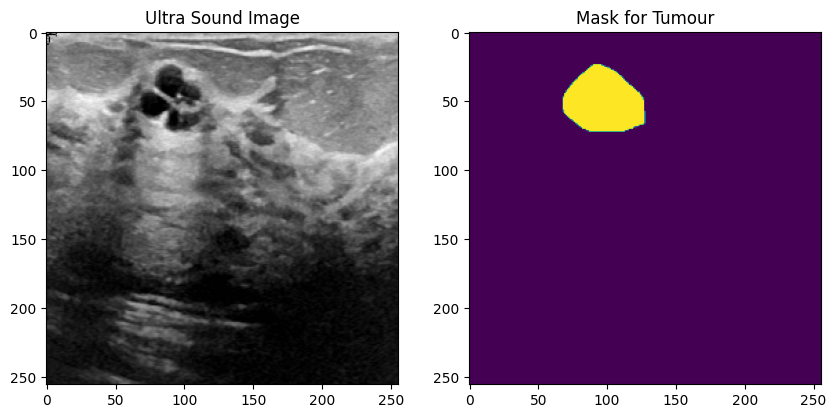

In [ ]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][2])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][2])
plt.title('Mask for Tumour')
plt.show()

In [ ]:
# Define the dice coefficient and dice loss functions
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = UNet_Attention(shape=(256, 256, 3))
myTransformer.compile(optimizer = 'Adam', loss = dice_loss, metrics = ['accuracy'] )

In [ ]:
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 100, verbose = 1)

Epoch 1/100
14/14 [==============================] - 94s 3s/step - loss: 0.8774 - accuracy: 0.5780
Epoch 2/100
14/14 [==============================] - 10s 746ms/step - loss: 0.8700 - accuracy: 0.4258
Epoch 3/100
14/14 [==============================] - 10s 744ms/step - loss: 0.8581 - accuracy: 0.4786
Epoch 4/100
14/14 [==============================] - 10s 746ms/step - loss: 0.8434 - accuracy: 0.7061
Epoch 5/100
14/14 [==============================] - 10s 746ms/step - loss: 0.7834 - accuracy: 0.7059
Epoch 6/100
14/14 [==============================] - 10s 745ms/step - loss: 0.6630 - accuracy: 0.9032
Epoch 7/100
14/14 [==============================] - 10s 741ms/step - loss: 0.6412 - accuracy: 0.9164
Epoch 8/100
14/14 [==============================] - 10s 743ms/step - loss: 0.6290 - accuracy: 0.9296
Epoch 9/100
14/14 [==============================] - 10s 741ms/step - loss: 0.6812 - accuracy: 0.8940
Epoch 10/100
14/14 [==============================] - 10s 747ms/step - loss: 0.6085 -

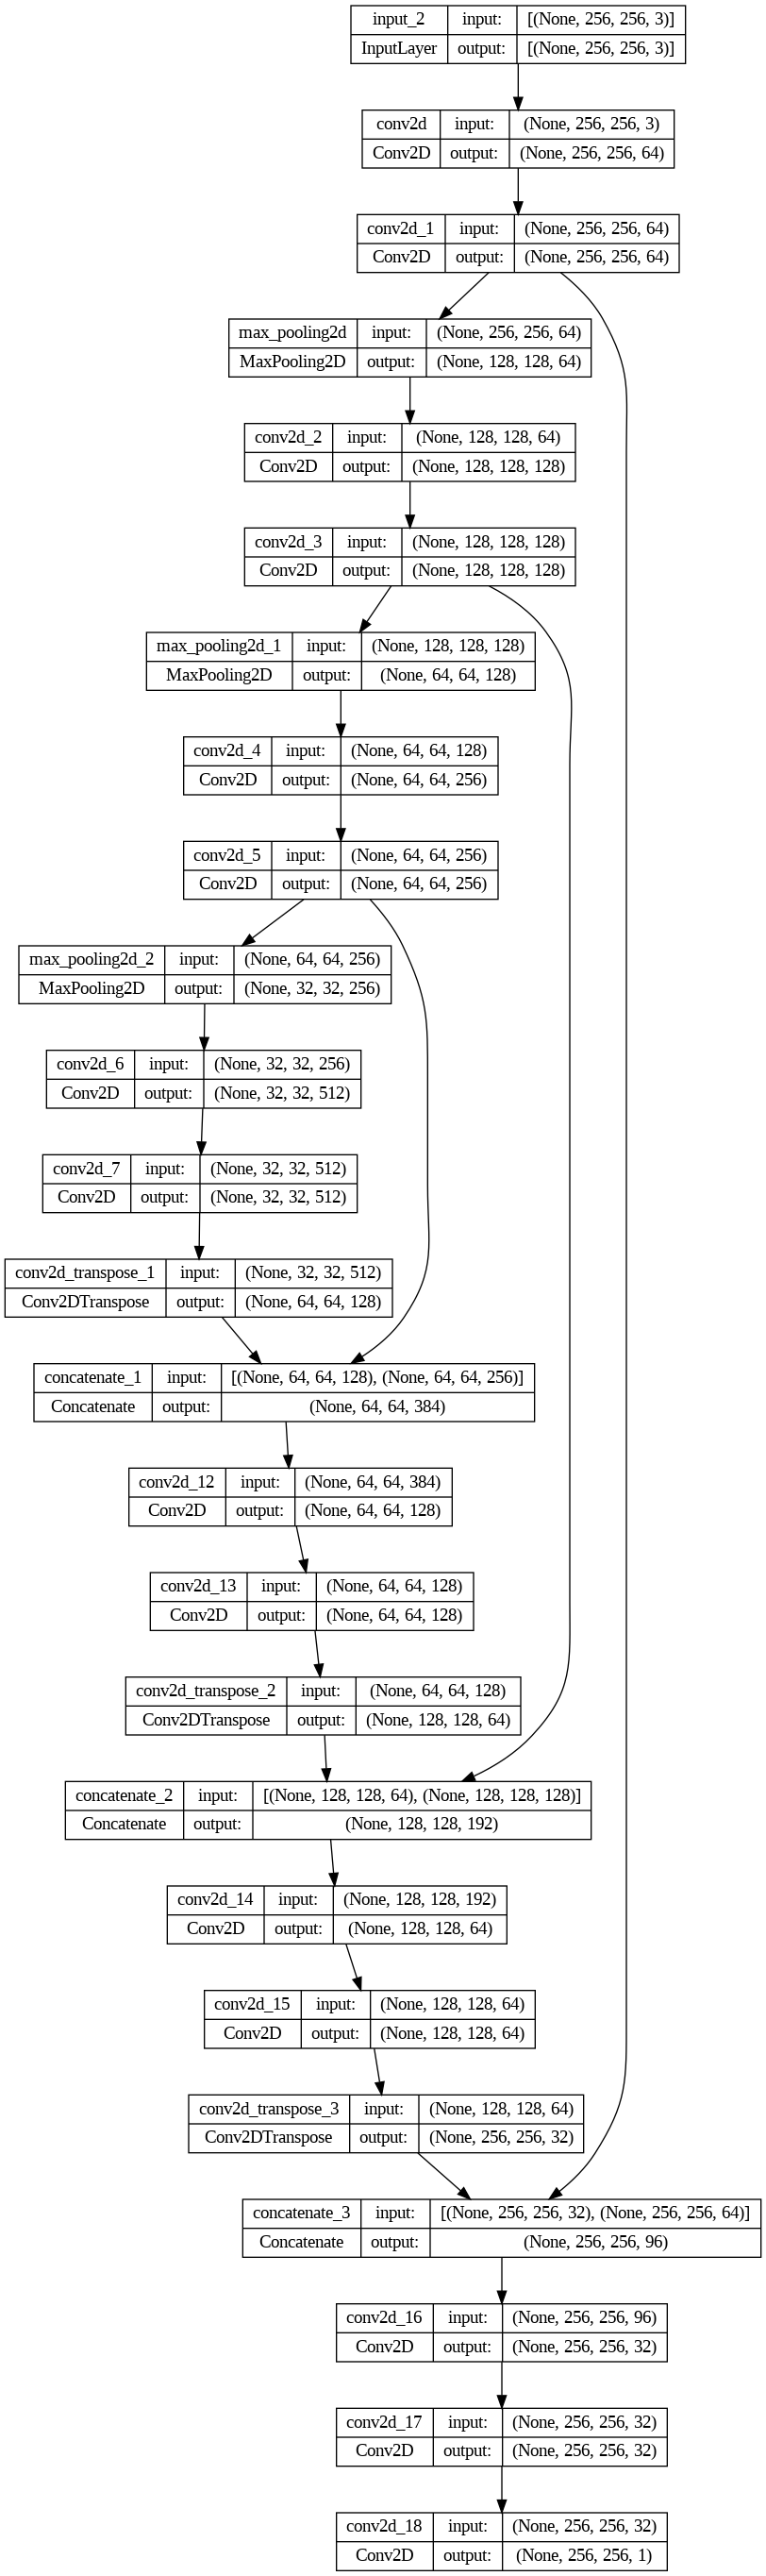

In [ ]:
from tensorflow.keras.utils import plot_model

model = myTransformer

# Visualize the model architecture
plot_model(model, to_file='unetAttention_model_architecture.png', show_shapes=True, show_layer_names=True)

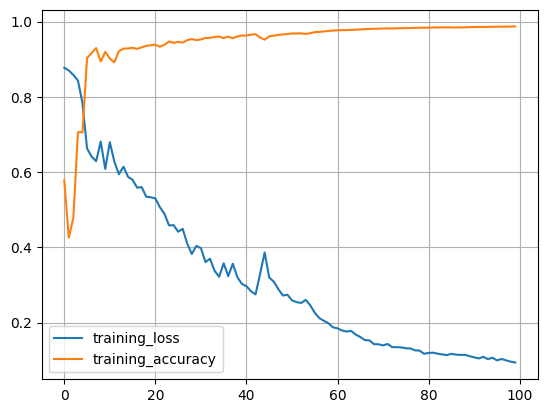

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

14/14 [==============================] - 3s 230ms/step


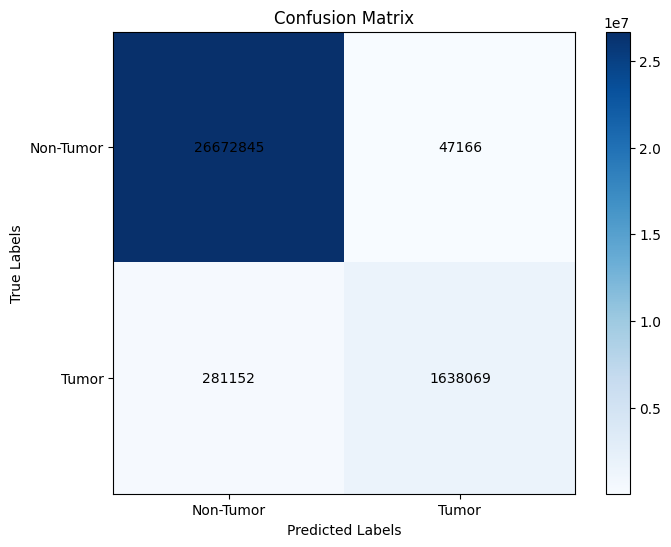

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predictions and true labels
# Replace predicted_labels and true_labels with your actual data
predicted_labels = myTransformer.predict(np.array(framObjTrain['img']))  # Assuming you're predicting on training data
true_labels = np.array(framObjTrain['mask'])

# Convert predicted labels to binary format
predicted_labels_binary = (predicted_labels > 0.5).astype(np.float32)
true_labels_binary = (true_labels > 0.5).astype(np.float32)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels_binary.flatten(), predicted_labels_binary.flatten())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(2), ['Non-Tumor', 'Tumor'])
plt.yticks(np.arange(2), ['Non-Tumor', 'Tumor'])

# Display values in each cell
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Assuming you have predictions and true labels
# Replace predicted_labels and true_labels with your actual data
predicted_labels = myTransformer.predict(np.array(framObjTrain['img']))  # Assuming you're predicting on training data
true_labels = np.array(framObjTrain['mask'])

# Convert predicted labels to binary format (if needed)
predicted_labels_binary = (predicted_labels > 0.5).astype(np.float32)
true_labels_binary = (true_labels > 0.5).astype(np.float32)

# Calculate F1 score
f1 = f1_score(true_labels_binary.flatten(), predicted_labels_binary.flatten())

print("F1 Score:", f1)

14/14 [==============================] - 3s 223ms/step
F1 Score: 0.9089133006478648


In [ ]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

1/1 [==============================] - 8s 8s/step


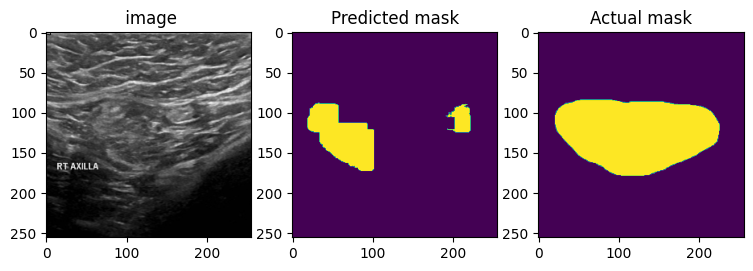

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

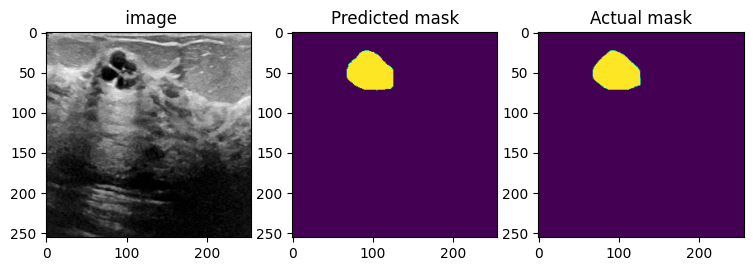

In [ ]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

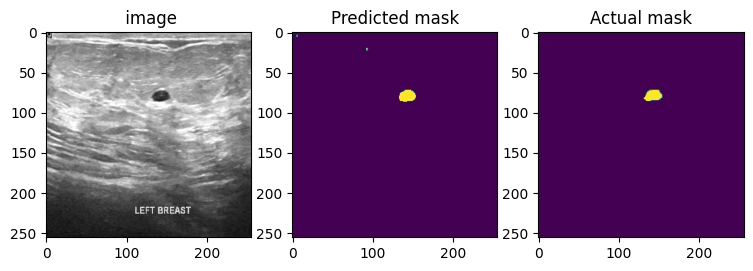

In [ ]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

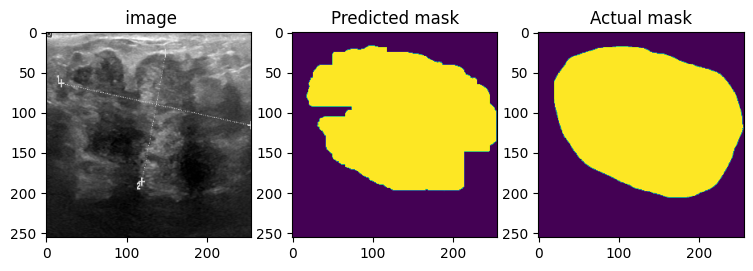

In [ ]:
Plotter(actuals[4], sixteenPrediction[4][:,:,0], masks[4])

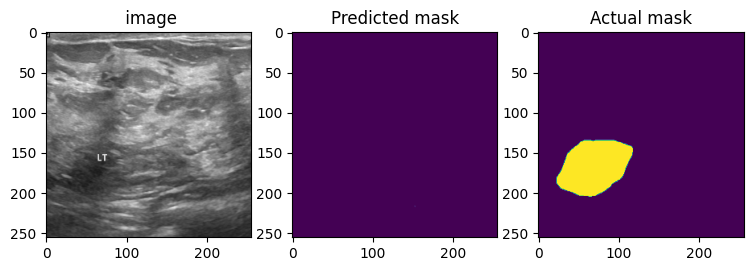

In [ ]:
Plotter(actuals[9], sixteenPrediction[9][:,:,0], masks[9])

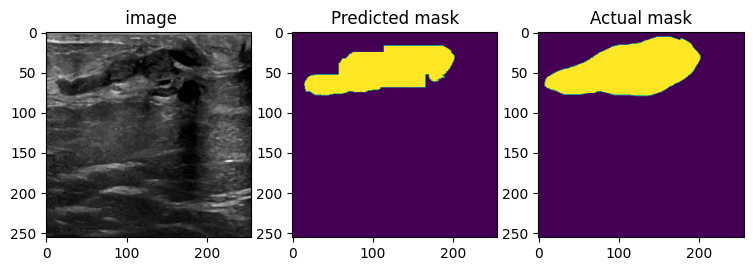

In [ ]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming you have predictions and true labels
# Replace predicted_labels and true_labels with your actual data
predicted_labels = myTransformer.predict(np.array(framObjTrain['img']))  # Assuming you're predicting on training data
true_labels = np.array(framObjTrain['mask'])

# Convert predicted labels to binary format (if needed)
predicted_labels_binary = (predicted_labels > 0.5).astype(np.float32)
true_labels_binary = (true_labels > 0.5).astype(np.float32)

# Calculate accuracy
accuracy = accuracy_score(true_labels_binary.flatten(), predicted_labels_binary.flatten())

print("Accuracy:", accuracy)


14/14 [==============================] - 3s 223ms/step
Accuracy: 0.9885360752690575
